# OPSD Results Report

This notebook auto-loads the **latest** run from `runs/*/results.yaml`, then generates: A clean metrics table (Model vs Baselines)

In [1]:
import os
import glob
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Resolve repo root
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) if os.path.basename(os.getcwd()) == "notebooks" else os.getcwd()
RUNS_DIR = os.path.join(REPO_ROOT, "runs")
plt.rcParams["figure.figsize"] = (10, 4)


## Find the latest run

We pick the most recently modified `runs/*/results.yaml`.

In [2]:
results_paths = glob.glob(os.path.join(RUNS_DIR, "*", "results.yaml"))
if not results_paths:
    raise FileNotFoundError(
        f"No results.yaml found under {RUNS_DIR}.\n"
        "Run: python3 src/run.py train --config configs/opsd_lstm.yaml"
    )

latest_results = max(results_paths, key=os.path.getmtime)
latest_run_dir = os.path.dirname(latest_results)

print("Latest run:", os.path.relpath(latest_run_dir, REPO_ROOT))
print("Results file:", os.path.relpath(latest_results, REPO_ROOT))

with open(latest_results, "r") as f:
    results = yaml.safe_load(f)

results.keys()


Latest run: runs/20251215_221621_opsd
Results file: runs/20251215_221621_opsd/results.yaml


dict_keys(['config_path', 'dataset', 'selection', 'best', 'baselines', 'metrics', 'checkpoint_path'])

## Extract metrics into a table

In [3]:
def _pick(d, *keys, default=None):
    cur = d
    for k in keys:
        if cur is None:
            return default
        cur = cur.get(k)
    return cur if cur is not None else default

dataset = results.get("dataset", "unknown")
selection = results.get("selection", {})
config_path = results.get("config_path", "")
checkpoint_path = results.get("checkpoint_path", results.get("checkpoint", ""))

# Model metrics: support both train/eval-only shapes
model_val = _pick(results, "metrics", "val") or _pick(results, "best", "val")
model_test = _pick(results, "metrics", "test")

base_val = _pick(results, "baselines", "val", default={}) or {}
base_test = _pick(results, "baselines", "test", default={}) or {}

rows = []
def add_row(split, name, m):
    if not m:
        return
    rows.append({
        "split": split,
        "model": name,
        "RMSE": float(m.get("RMSE", np.nan)),
        "MAE": float(m.get("MAE", np.nan)),
        "sMAPE": float(m.get("sMAPE", np.nan)),
    })

add_row("val", "Neural net", model_val)
add_row("val", "Baseline lag24", base_val.get("lag24"))
add_row("val", "Baseline lag168", base_val.get("lag168"))

add_row("test", "Neural net", model_test)
add_row("test", "Baseline lag24", base_test.get("lag24"))
add_row("test", "Baseline lag168", base_test.get("lag168"))

df_metrics = pd.DataFrame(rows)
df_metrics


,split,model,RMSE,MAE,sMAPE
0,val,Neural net,3813.737162,2321.586383,4.293451
1,val,Baseline lag24,7118.771629,4665.408258,8.613727
2,val,Baseline lag168,3992.635488,2295.221110,4.206557
3,test,Neural net,3627.840633,2347.321179,4.560950
4,test,Baseline lag24,6182.093955,4085.158230,7.801820
5,test,Baseline lag168,4163.575137,2436.975104,4.625449


### Pretty table (Markdown)

In [5]:
disp = df_metrics.copy()
for c in ["RMSE", "MAE", "sMAPE"]:
    disp[c] = disp[c].map(lambda x: f"{x:.2f}" if pd.notnull(x) else "—")

md_table = disp.pivot(index="model", columns="split", values=["RMSE", "MAE", "sMAPE"])
md_table.columns = [f"{metric.upper()} ({split})" for metric, split in md_table.columns]
md_table = md_table.reset_index()

print(md_table.to_markdown(index=False))


| model           |   RMSE (test) |   RMSE (val) |   MAE (test) |   MAE (val) |   SMAPE (test) |   SMAPE (val) |
|:----------------|--------------:|-------------:|-------------:|------------:|---------------:|--------------:|
| Baseline lag168 |       4163.58 |      3992.64 |      2436.98 |     2295.22 |           4.63 |          4.21 |
| Baseline lag24  |       6182.09 |      7118.77 |      4085.16 |     4665.41 |           7.8  |          8.61 |
| Neural net      |       3627.84 |      3813.74 |      2347.32 |     2321.59 |           4.56 |          4.29 |


## Report figure

A simple bar chart comparing **Test RMSE** across the model and baselines. (Lower is better.)

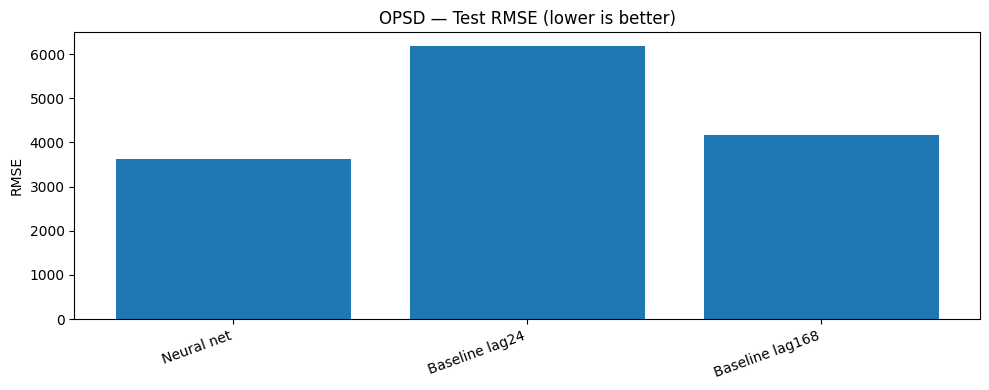

In [6]:
test_rows = df_metrics[df_metrics["split"] == "test"].copy()
test_rows = test_rows.dropna(subset=["RMSE"])

plt.figure()
plt.bar(test_rows["model"], test_rows["RMSE"])
plt.title(f"{dataset.upper()} — Test RMSE (lower is better)")
plt.ylabel("RMSE")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


### Save figure + table artifacts

In [7]:
out_png = os.path.join(latest_run_dir, "report_rmse_test.png")
out_md = os.path.join(latest_run_dir, "report_table.md")

# Save the figure
plt.figure()
plt.bar(test_rows["model"], test_rows["RMSE"])
plt.title(f"{dataset.upper()} — Test RMSE (lower is better)")
plt.ylabel("RMSE")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(out_png, dpi=200)
plt.close()

# Save the markdown table
with open(out_md, "w") as f:
    f.write(md_table.to_markdown(index=False) + "\n")

print("Saved:", os.path.relpath(out_png, REPO_ROOT))
print("Saved:", os.path.relpath(out_md, REPO_ROOT))


Saved: runs/20251215_221621_opsd/report_rmse_test.png
Saved: runs/20251215_221621_opsd/report_table.md


## Suggested README snippet

Use this block under a **Results** section.

In [8]:
png_rel = os.path.relpath(out_png, REPO_ROOT).replace("\\", "/")
md_rel = os.path.relpath(out_md, REPO_ROOT).replace("\\", "/")

snippet = f"""### Results (latest run)

**Dataset:** `{dataset}`  
**Config:** `{config_path}`  

![Test RMSE comparison]({png_rel})

(Full table: `{md_rel}`)
"""

print(snippet)


### Results (latest run)

**Dataset:** `opsd`  
**Config:** `configs/opsd_lstm.yaml`  

![Test RMSE comparison](runs/20251215_221621_opsd/report_rmse_test.png)

(Full table: `runs/20251215_221621_opsd/report_table.md`)



In [9]:
# Write a single README_results.md at repo root
readme_out = os.path.join(REPO_ROOT, "README_results.md")

png_rel = os.path.relpath(out_png, REPO_ROOT).replace(os.sep, "/")
md_rel  = os.path.relpath(out_md, REPO_ROOT).replace(os.sep, "/")
run_rel = os.path.relpath(latest_run_dir, REPO_ROOT).replace(os.sep, "/")
res_rel = os.path.relpath(latest_results, REPO_ROOT).replace(os.sep, "/")

table_md = md_table.to_markdown(index=False)

content = f"""# Results (latest run)

**Dataset:** `{dataset}`  
**Config:** `{config_path}`  
**Run folder:** `{run_rel}`

![Test RMSE comparison]({png_rel})

## Metrics table
(Generated from `{res_rel}`)

{table_md}

Full table file: `{md_rel}`
"""

with open(readme_out, "w") as f:
    f.write(content)

print("Wrote:", os.path.relpath(readme_out, REPO_ROOT).replace(os.sep, "/"))

Wrote: README_results.md
